In [4]:
from model_update import DDPM_Predict, Diffusion
from data import ESM2Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn.utils.rnn import pad_sequence
import os
import pandas as pd
from tqdm import tqdm
import math
from scipy.stats import norm
import random
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
random.seed(418)  # 设置种子值


In [5]:
### SET GPU OR CPU ###
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device detected: {device}")
else:
    device = torch.device("cpu")
    print(f"GPU device not detected. Using CPU: {device}")
    


GPU device not detected. Using CPU: cpu


torch.Size([4, 224, 1281])
O09710_9
tensor([-5.1666, -5.1666, -5.1666, -5.1666, -5.1666, -5.1666, -5.1666,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
    

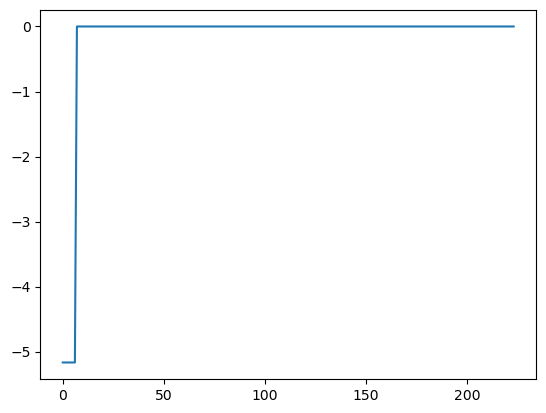

In [7]:
# 获取所有ESM编码文件路径列表
esm_files = list(Path("data/esm_encodings").glob("*.pt"))

# 划分训练集和测试集
train_files, test_files = train_test_split(esm_files, test_size=0.2, random_state=42)
train_ESM_2_dataset = ESM2Dataset(train_files)
test_ESM_2_dataset = ESM2Dataset(test_files)


def collate_fn(batch):
    """
    输入: batch 是一个列表，包含若干个 (acc, esm_embedding, epitope_label)
    输出: padded 的 batch，包括 mask
    """
    accs, embeddings, labels = zip(*batch)

    # pad_sequence 默认按第一维对齐，batch_first=True 输出形状为 (B, L, D)
    padded_embeddings = pad_sequence(embeddings, batch_first=True)  # (B, L, D)
    padded_labels = pad_sequence(labels, batch_first=True)          # (B, L)

    # 创建 attention mask：True 表示有效位置，False 表示padding
    attention_mask = torch.zeros_like(padded_labels, dtype=torch.bool)
    for i, label in enumerate(labels):
        attention_mask[i, :label.size(0)] = True

    return accs, padded_embeddings, padded_labels, attention_mask
    
train_ESM_2_dataloader = DataLoader(train_ESM_2_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_ESM_2_dataloader = DataLoader(test_ESM_2_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


for acc, esm, epitope, attention_mask in test_ESM_2_dataloader:
    print(esm.shape)
    print(acc[0])
    print(epitope[0])
    print(attention_mask[0])
    
    plt.plot(epitope[0])
    break

In [ ]:
# checkpoint
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f'Checkpoint saved to {checkpoint_path}')

def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [ ]:
# model = BepiPredDDPM()
# diffusion = Diffusion()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# def train(model, dataloader, optimizer, steps=1000, device=device, epochs=10):
#     model.train()
#     epochs_losses = []  # 记录每个epoch的平均损失

#     for epoch in range(epochs):
#         progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
#         loss_record= []
#         for x0, esm_len, epitope_labels, epitope_len in progress_bar:  # x0: 真实ESM嵌入 [B, L, D]
#             x0 = x0.to(device)
#             epitope_labels = epitope_labels.to(device)
            
#             # 1. 随机采样时间步和噪声
#             t = torch.randint(0, steps, (x0.size(0),), device=device)
#             noise = torch.randn_like(x0)
            
#             # 2. 前向加噪（根据噪声调度）
#             xt = diffusion.q_sample(x0, t)
#             t = t.float()

#             # 3. 预测噪声并计算损失
#             pred_noise, epitope_prob = model(xt, t)

#             # 4. 计算表位分类损失
#             loss_diffusion = F.mse_loss(pred_noise, noise)
#             loss_epitope = F.binary_cross_entropy(epitope_prob, epitope_labels.unsqueeze(-1))  # 需提供真实表位标签
#             total_loss = 0.3 * loss_diffusion + 0.7 * loss_epitope  # 加权平衡
            
#             # 4. 反向传播
#             optimizer.zero_grad()
#             total_loss.backward()
#             loss_record.append(total_loss.item())
#             optimizer.step()
            
#             # 5. 记录损失
#             progress_bar.set_postfix({"loss": total_loss.item()})
#             epoch_loss = torch.tensor(loss_record).mean().item()

#         epochs_losses.append(epoch_loss)
#         # 每15个epoch保存一次checkpoint
#         if (epoch + 1) % 5 == 0:
#             save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir)
#             print(f"Epoch {epoch + 1}, Loss_Mean: {epoch_loss}", end="\r")
#             plt.plot(epochs_losses)
#             plt.xlabel('Epochs')
#             plt.ylabel('Loss')
#             plt.title('Training Loss')
#             plt.show()



In [ ]:
# def eval_model(model, dataloader, device=device):
#     probs, labels = [], []
#     model.eval()
#     with torch.no_grad():
#         for x0, esm_len, epitope_labels, epitope_len in dataloader:
#             _, epitope_prob = model(x0.to(device), torch.zeros(x0.size(0)).to(device))
#             probs.append(epitope_prob.squeeze(-1).cpu())
#             labels.append(epitope_labels.cpu())
            
    
#     probs = torch.cat(probs).numpy()
#     labels = torch.cat(labels).numpy()
#     # precision, recall, _ = precision_recall_curve(labels, probs)
#     # pr_auc = auc(recall, precision)  # 更关注正类的指标
#     return probs, labels

In [ ]:
# train(model, train_dataloader, optimizer=optimizer)

In [ ]:
# probs, labels = eval_model(model, test_dataloader)

In [ ]:
def train(model, dataloader, optimizer, steps=1000, device=device, epochs=10):
    model.train()
    epochs_losses = []  # 记录每个epoch的平均损失

    for epoch in range(epochs):
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        loss_record= []
        for esm, esm_len, mask, mask_len in progress_bar:  # esm: 真实ESM嵌入 [B, L, D]
            esm = esm.to(device)
            mask = mask.to(device)
            
            # print(mask.shape)
            # print(esm.shape)
            # 1. 随机采样时间步和噪声
            t = torch.randint(0, steps, (mask.size(0),), device=device)
            noise = torch.randn_like(mask)
            
            # 2. 前向加噪（根据噪声调度）
            noisy_mask = diffusion.q_sample(mask.unsqueeze(-1), t)
            t = t.float()

            # 3. 预测噪声并计算损失
            pred_noise = model(noisy_mask, esm, t)

            # 4. 计算表位分类损失
            loss = F.mse_loss(pred_noise, noise)
            
            # 4. 反向传播
            optimizer.zero_grad()
            loss.backward()
            loss_record.append(loss.item())
            optimizer.step()
            
            # 5. 记录损失
            progress_bar.set_postfix({"loss": loss.item()})
            epoch_loss = torch.tensor(loss_record).mean().item()

        epochs_losses.append(epoch_loss)
        # 每15个epoch保存一次checkpoint
        if (epoch + 1) % 5 == 0:
            save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir)
            print(f"Epoch {epoch + 1}, Loss_Mean: {epoch_loss}", end="\r")
            plt.plot(epochs_losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()



Checkpoint saved to ./checkpoints/checkpoint_epoch_5.pth


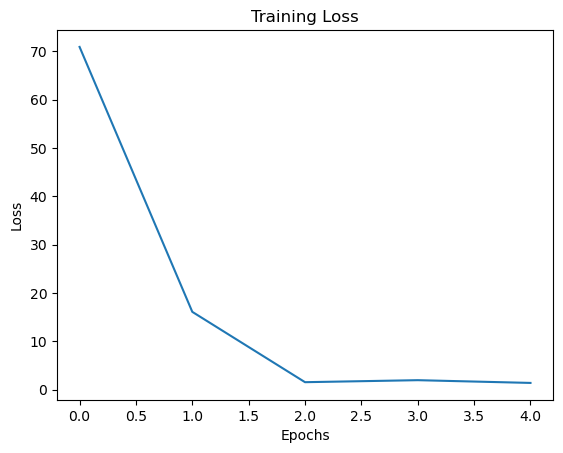

Checkpoint saved to ./checkpoints/checkpoint_epoch_10.pth


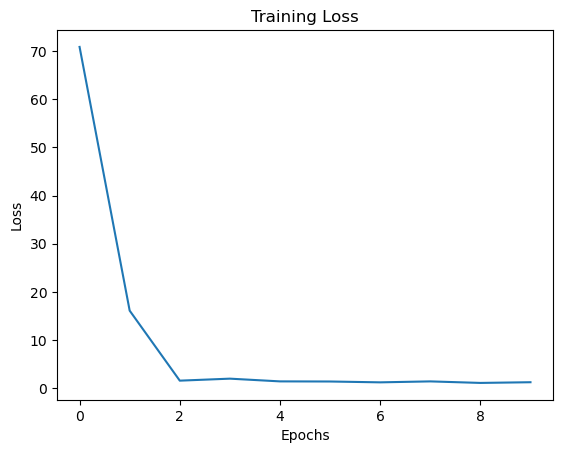

In [ ]:
DDPM_Predicet_model = DDPM_Predict()
diffusion = Diffusion()
optimizer = optim.Adam(DDPM_Predicet_model.parameters(), lr=0.001)
train(DDPM_Predicet_model, train_ESM_2_dataloader, optimizer)


In [ ]:
@torch.no_grad()
def ddpm_sampling(model, esm_seq, num_steps=1000):
    """
    Args:
        model: 训练好的 EpitopeTransformerDDPM 模型
        scheduler: 噪声调度器（如 SimpleNoiseScheduler）
        esm_seq: (B, L) 蛋白质序列
        bepi_scores: (B, L) BepiPred得分（0~1）
        num_steps: T，采样步数
        
    Returns:
        x0: (B, L) 最终生成的掩码（0~1）
    """

    B, L,  _= esm_seq.shape
    x_t = torch.randn(B, L, 1).to(device)  # 初始纯噪声

    for t_index in range(num_steps - 1, -1, -1):
        t = torch.full((B,), t_index, device=device, dtype=torch.long)
        # 模型预测噪声
        pred_noise = model(x_t, esm_seq, t).unsqueeze(-1)  # (B, L, 1)

        x_t = diffusion.p_sample(x_t, pred_noise, t, t_index)
        
    # 输出最终 x0
    x0 = x_t.squeeze(-1)  # (B, L)
    x0 = torch.sigmoid(x0)    # 保证在 [0,1] 概率范围（推荐）

    return x0  # 每个位点为表位的概率分布



In [ ]:
def sample(test_dataloader):
    model.eval()
    with torch.no_grad():
        for esm, esm_len, mask, mask_len in test_dataloader:
            esm = esm.to(device)
            mask = mask.to(device)
            pred_mask = ddpm_sampling(model, esm)
            pred_mask = pred_mask.cpu().numpy()
    return mask, pred_mask
mask, pred_mask = sample(test_ESM_2_dataloader)
